## Imports

In [1]:
import sys, os
import pandas as pd
import polars as pl
import numpy as np
from dotenv import load_dotenv

sys.path.append('/Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting')
# when running on JupyterHub the dot-env-path needs to be adapted
load_dotenv("../.env")

datetime_format = "%Y-%m-%d %H:%M%z"

%load_ext autoreload

In [48]:
%autoreload

In [ ]:
from src.neuro_symbolic_demand_forecasting.database.snowflake import SnowflakeDao


sf_dao = SnowflakeDao(
    url=os.getenv("SNOWFLAKE_URL"),
    uid=os.getenv("SNOWFLAKE_UID"),
    pwd=os.getenv("SNOWFLAKE_PASSWORD"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
)

sf_dao.connect()

In [ ]:
contract_df = sf_dao.fetch_list("SELECT * FROM SANDBOX.KATRIN.CONTRACT_DATA")
contract_df

In [ ]:
from src.neuro_symbolic_demand_forecasting.helpers.constants import P4_TS_SUMMER

start, end = "2023-05-01 00:00+02:00", "2023-05-16 00:00+02:00"
columns = "EAN_SHA256, LDN, ODN, READINGDATE, LDN_DIFF, ODN_DIFF"
df = sf_dao.fetch_list(f"SELECT {columns} FROM {P4_TS_SUMMER} WHERE READINGDATE>='{start}' AND READINGDATE<='{end}';")
data = df 
data.head()

# data.write_csv("./p4_data_extract.csv")


In [ ]:
data = pl.read_csv("./p4_data_extract.csv", try_parse_dates=True)
data

In [ ]:
data = data.filter(pl.col('readingdate').dt.minute() == 0)

## Checking and filtering for missing data

In [ ]:
for k, g in data.group_by(['ean_sha256']):
    print(g[0:20])
    break

In [ ]:
min_length = (data['readingdate'].max() - data['readingdate'].min()).days * 24 

missing_points = pl.DataFrame()
for key, group  in data.group_by(['ean_sha256']):
    if len(group) < min_length:
        missing_points = pl.concat([missing_points, group])

missing_points

In [ ]:
missing_points['ean_sha256'].unique()

In [ ]:
df_for_train = data.filter(~pl.col('ean_sha256').is_in(missing_points['ean_sha256'].unique()))
# df_for_train = df_for_train.filter(pl.col('readingdate').dt.minute() == 0)
data, df_for_train

In [ ]:
data = df_for_train

## Dividing data into PV and non-PV cluster

In [ ]:
data = data.with_columns(pl.col('odn_diff').cast(pl.Float64), pl.col('ldn_diff').cast(pl.Float64))

In [ ]:
grouped = data.group_by('ean_sha256').agg(pl.sum('odn_diff').alias('odn_sum'))


In [ ]:
pv = data.filter(pl.col('ean_sha256').is_in(grouped.filter(pl.col('odn_sum') > 0)['ean_sha256']))
non_pv = data.filter(pl.col('ean_sha256').is_in(grouped.filter(pl.col('odn_sum') <= 0)['ean_sha256']))

pv, non_pv

## Calculate Region Proportions

what are the weights of the regions of the smart meter locations

and what weather stations and weather forecast grid points can we utilize for a weighted forecast

## Loading and Cleaning data

In [2]:
from src.neuro_symbolic_demand_forecasting.darts.cleaning import *

df = pl.read_csv('./p4_data_june_2023.csv', columns=['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE'],
                 try_parse_dates=True,
                 new_columns=[f.lower() for f in ['EAN_SHA256', 'LDN', 'ODN', 'READINGDATE']])


cleaned_df = clean_data(df)

del df # hopefully freeing up memory
cleaned_df.plot()

Filtering out 2023-06-30 21:45:00+00:00 2023-05-31 21:00:00+00:00 2884.0
Filtering out timeseries with less than 2884.0
Generating intervals
Aggregating data into one timeseries: cols: gross
Checking for outliers above 1027744.5 and below -1771068.0
Linearly interpolation outliers detected at the indices: shape: (4,)
Series: 'index' [u32]
[
	848
	2449
	2481
	2758
]


:Curve   [index]   (gross)

## Pulling weather data

In [3]:
actuals = pl.read_csv('./2023-06-amsterdam-actuals.csv')

actuals.columns

actual_cols = [ pl.col(c) for c in [
 'datetime_from',
 'wind_speed',
 'wind_gust_speed',
 'air_temperature',
 'relative_humidity',
 'air_pressure',
 'visibility',
#  'rain_gauge_precipitation_duration',
 'cloud_cover',
#  'pws_precipitation_intensity',
#  'pws_precipitation_duration',
 'global_radiation',
 'dew_point_temperature',
 ]]

selected_actuals = actuals.select(actual_cols)
selected_actuals = selected_actuals.with_columns(pl.col('datetime_from').str.to_datetime())
selected_actuals

datetime_from,wind_speed,wind_gust_speed,air_temperature,relative_humidity,air_pressure,visibility,cloud_cover,global_radiation,dew_point_temperature
datetime[μs],f64,f64,f64,f64,f64,f64,str,f64,f64
2023-06-01 00:00:00,5.23,7.65,284.45,0.85,102491.0,31500.0,null,0.0,282.15
2023-06-01 00:10:00,5.28,8.62,284.55,0.85,102481.0,32200.0,null,0.0,282.15
2023-06-01 00:20:00,5.87,8.84,284.55,0.86,102471.0,26600.0,null,0.0,282.25
2023-06-01 00:30:00,6.16,9.28,284.45,0.86,102471.0,27600.0,null,0.0,282.25
2023-06-01 00:40:00,5.85,9.17,284.35,0.86,102471.0,26600.0,null,0.0,282.15
…,…,…,…,…,…,…,…,…,…
2023-07-29 23:10:00,4.62,6.35,289.85,0.88,100772.0,14900.0,"""2.0""",0.0,287.85
2023-07-29 23:20:00,5.15,6.55,289.95,0.87,100772.0,14300.0,"""6.0""",0.0,287.85
2023-07-29 23:30:00,4.9,6.12,289.95,0.87,100782.0,15000.0,"""8.0""",0.0,287.95


In [4]:
weather_df = pl.read_csv('../2023_weather_data_06_run_summer.csv', try_parse_dates=True).sort('valid_datetime')#.filter((pl.col('valid_datetime') < max_date) & (pl.col('valid_datetime') >= min_date))

selected_weather = weather_df.select(
    pl.col('valid_datetime'), pl.col('wind_speed_10m'), pl.col('t_instant_ground_2m'),  
    pl.col('grad_accum_ground_0m'),  pl.col('rain_instant_ground_0m'), pl.col('pres_instant_ground_0m'),
    pl.col('wind_blast_speed_10m')
)
selected_weather

# selected_weather.with_columns(pl.col('grad_accum_ground_0m') < 0).select(pl.col('valid_datetime'), pl.col('grad_accum_ground_0m'))

valid_datetime,wind_speed_10m,t_instant_ground_2m,grad_accum_ground_0m,rain_instant_ground_0m,pres_instant_ground_0m,wind_blast_speed_10m
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00 UTC,5.08021,282.15723,0.0,0.00009,98975.19,10.466365
2023-04-01 01:00:00 UTC,4.670426,282.03906,0.0,0.000083,98986.19,9.381132
2023-04-01 02:00:00 UTC,4.5113754,281.7544,0.0,0.000088,98998.44,8.600689
2023-04-01 03:00:00 UTC,4.049578,281.49512,0.0,0.000094,99022.5,8.31484
2023-04-01 04:00:00 UTC,3.5291646,281.38184,0.0,0.000231,99044.81,7.4436874
…,…,…,…,…,…,…
2023-07-31 19:00:00 UTC,4.1694837,290.3694,25900.188,0.000036,100127.75,8.043049
2023-07-31 20:00:00 UTC,3.9396036,290.45752,890.4375,1.1921e-7,100079.75,7.7695036
2023-07-31 21:00:00 UTC,3.7858133,290.16504,0.0,0.0,100024.5,7.3689775


In [24]:
selected_weather.plot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Data Prep

In [5]:
from sklearn.preprocessing import MinMaxScaler

meter_data_scaler = MinMaxScaler()
weather_data_scaler = MinMaxScaler()
actuals_data_scaler = MinMaxScaler()

In [6]:
scaled_meter = cleaned_df.to_pandas()

scaled_meter.set_index('readingdate', inplace=True)

scaled_meter = pd.DataFrame(meter_data_scaler.fit_transform(scaled_meter.values), columns=scaled_meter.columns, index=scaled_meter.index)



scaled_actuals = selected_actuals.to_pandas()
scaled_actuals.set_index('datetime_from', inplace=True)
scaled_actuals = pd.DataFrame(actuals_data_scaler.fit_transform(scaled_actuals.values), columns=scaled_actuals.columns, index=scaled_actuals.index)
scaled_actuals = scaled_actuals.resample('15min').mean()


scaled_weather = selected_weather.to_pandas()
scaled_weather.set_index('valid_datetime', inplace=True)
scaled_weather = pd.DataFrame(weather_data_scaler.fit_transform(scaled_weather.values), columns=scaled_weather.columns, index=scaled_weather.index)
scaled_weather = scaled_weather.resample('15min').ffill()

In [8]:
from darts import TimeSeries

# scaled_weather.index.min(), scaled_weather.index.max(), scaled_meter.index.min(), scaled_meter.index.max()
set(scaled_meter[:-3].index.tolist()).difference(scaled_weather.index.tolist())

meter_ts = TimeSeries.from_dataframe(scaled_meter) # last three are not in weather_ts so we are skipping them
weather_ts = TimeSeries.from_dataframe(scaled_weather, freq='15min')
actuals_ts = TimeSeries.from_dataframe(scaled_actuals, freq='15min')

len(meter_ts), len(weather_ts), len(actuals_ts)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/darts/timeseries.py:737: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the 

(2884, 11709, 5664)

### Data Split

In [9]:
train_meter, val_meter = meter_ts.split_after(0.8)

## Linear Regression

In [60]:
from darts.models import RegressionModel

regr_model = RegressionModel(
    lags=5*24*4,
    lags_past_covariates=5*24*4,
    # lags_future_covariates=(),
    output_chunk_length=int(0.5*24*4),
    add_encoders={
        'tz': 'UTC'
    }

)

regr_model = regr_model.fit(train_meter, past_covariates=weather_ts)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Axes: xlabel='readingdate'>

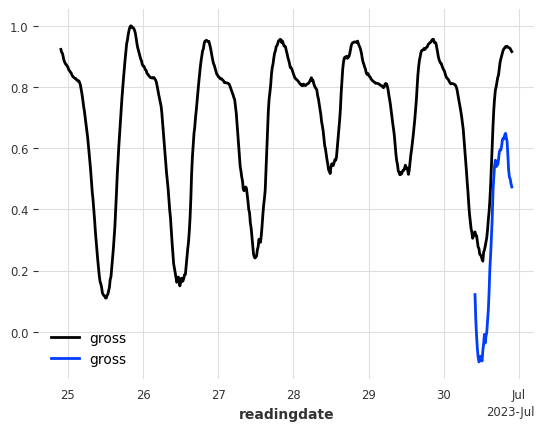

In [59]:
forecast, actual  = val_meter[:-48], val_meter[-48:]

val_meter.plot()

regr_model.predict(48, forecast, past_covariates=weather_ts).plot()

In [39]:
backtest = regr_model.historical_forecasts(
    meter_ts,
    past_covariates=weather_ts,
    start=val_meter.start_time(),
    forecast_horizon=96,
    stride=96,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

### Evaluation

MAPE = 65.43%
SMAPE = 98.87%
MAE = 0.30%


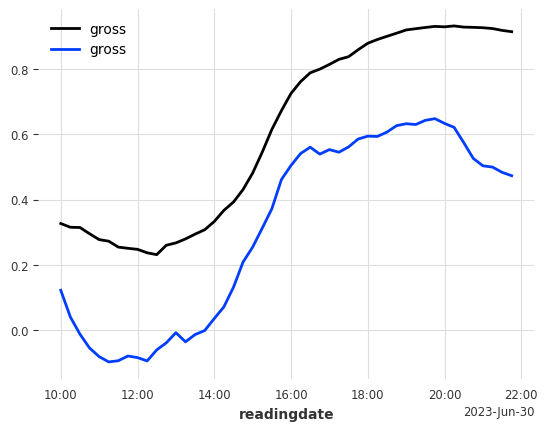

In [57]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]

actual.plot()

pred = regr_model.predict(48, forecast, weather_ts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))


In [21]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=meter_ts, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    meter_ts[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(meter_ts, backtest)))

## Py Torch Settings 

### Custom Loss

In [56]:
import torch
import torch.nn as nn

# Define your custom loss function
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        # Define your loss components here

    def forward(self, output, target):
        # Calculate your custom loss
        # print('outputted', output)
        # print('target', target)
        loss = torch.mean((output - target)**2)  # Example custom loss (MSE)
        return loss
    

torch_kwargs = {
    'loss_fn': CustomLoss()
}


### Early stopping

In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

## LSTM with Darts

In [35]:
from darts.models import (
    NBEATSModel,
    BlockRNNModel
)

model_name = "BlockRNN_test"
model_lstm = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=4,
    n_epochs=10,
    random_state=0,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    **torch_kwargs
)

In [38]:
model_lstm.fit(
    train_meter,
    past_covariates=weather_ts,
    val_series=val_meter,
    val_past_covariates=weather_ts,
    # future_covariates=actuals_ts
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Attempting to retrain/fine-tune the model without resuming from a checkpoint. This is currently discouraged. Consider model `BlockRNNModel.load_weights()` to load the weights for fine-tuning.
/Users/katringrunert/Library/Caches/pypoetry/virtualenvs/neuro-symbolic-demand-forecasting-yu9KrGz6-py3.12/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/katringrunert/Projects/Uni/thesis/neuro-symbolic-demand-forecasting/notebooks/darts_logs/BlockRNN_test/checkpoints exists and is not empty.

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | CustomLoss       | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.4 K 
4 | fc            | S

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=4, n_epochs=10, random_state=0, model_name=BlockRNN_test, save_checkpoints=True, force_reset=True, loss_fn=CustomLoss())

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 29.01%
SMAPE = 22.99%
MAE = 0.12%


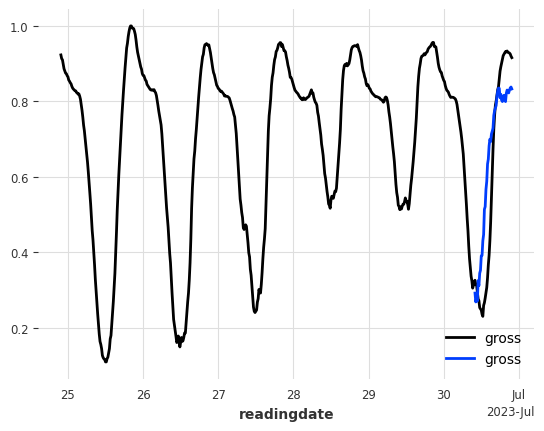

In [62]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]

val_meter.plot()

pred = model_lstm.predict(48, forecast, weather_ts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))


## TFTModel



In [76]:
from darts.models import TFTModel
from darts import TimeSeries


input_chunk_length = 5 * 24 * 4
forecast_horizon = 1 * 24 * 4
# use `add_encoders` as we don't have future covariates
# from Paper
# model = TFTModel(
#     input_chunk_length=input_chunk_length, # encoder_length
#     output_chunk_length=forecast_horizon,
#     num_attention_heads=2,
#     hidden_size=60,
#     hidden_continuous_size=30,
#     lstm_layers=2,
#     batch_size=1024,
#     n_epochs=5,
#     dropout=0.7,
#     # add_encoders={"cyclic": {"future": ["month"]}},
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 0.001}, # learning rate
#     use_static_covariates=False,
#     random_state=42,
# )

model= TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    # hidden_size=32,
    # lstm_layers=2,
    # batch_size=16,
    n_epochs=5,
    # dropout=0.1,
    # add_encoders={"cyclic": {"future": ["month"]}},
    # use_static_covariates=False,
    # add_relative_index=False,
    # optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    **torch_kwargs # custom loss
)

### Training

In [37]:
print(train_meter.time_index.min(), train_meter.time_index.max())
print(weather_ts.time_index.min(), weather_ts.time_index.max())
print(actuals_ts.time_index.min(), actuals_ts.time_index.max())

2023-06-01 00:00:00 2023-06-24 21:30:00
2023-04-01 00:00:00 2023-07-31 23:00:00
2023-06-01 00:00:00 2023-07-29 23:45:00


In [66]:
actuals_ts.columns

Index(['wind_speed', 'wind_gust_speed', 'air_temperature', 'relative_humidity',
       'air_pressure', 'visibility', 'cloud_cover', 'global_radiation',
       'dew_point_temperature'],
      dtype='object', name='component')

In [57]:
weather_ts.columns

Index(['wind_speed_10m', 't_instant_ground_2m', 'grad_accum_ground_0m',
       'rain_instant_ground_0m', 'pres_instant_ground_0m',
       'wind_blast_speed_10m'],
      dtype='object', name='component')

In [17]:
# train_meter = train_meter[12:]
# weather_ts = weather_ts[:8496]
# weather_ts = weather_ts[5856:]
# len(train_meter), len(weather_ts[:8496]), len(actuals_ts)

In [77]:
dummy_covariate = pd.Series(0, index=train_meter.time_index)  # Adjust the constant value as needed


wts = weather_ts[['wind_speed_10m', 'grad_accum_ground_0m', 'pres_instant_ground_0m', 't_instant_ground_2m']]
ats = actuals_ts[['wind_speed', 'global_radiation', 'air_pressure', 'air_temperature']]
# fit the model with past covariates
model.fit(
    train_meter, 
    past_covariates=ats, 
    future_covariates=wts, 
    val_series=val_meter,
    val_past_covariates=ats,
    val_future_covariates=wts, 
    verbose=True,
    # trainer=pl_trainer_kwargs
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | CustomLoss                       | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
5  | encoder_vsn                       | _VariableSelectionNetwork        | 5.9 K 
6  | decoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
7  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
8  | static_cont

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

### Evaluation

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 18.06%
SMAPE = 14.51%
MAE = 0.07%


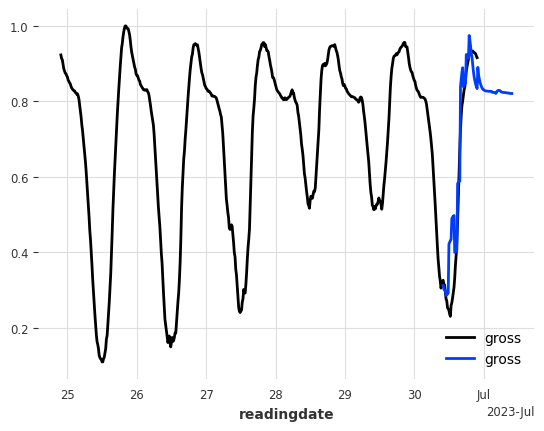

In [72]:
from darts.metrics import mape, smape, mae

# regr_model.predict(1)
# eval_model(regr_model, val_weather)

# plot acutals against the predicted horizon
forecast, actual  = val_meter[:-48], val_meter[-48:]
# train_meter.plot()
val_meter.plot()

pred = model.predict(n=96, series=forecast, past_covariates=wts)
pred.plot()

print("MAPE = {:.2f}%".format(mape(actual, pred)))
print("SMAPE = {:.2f}%".format(smape(actual, pred)))
print("MAE = {:.2f}%".format(mae(actual, pred)))

### Explainability

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

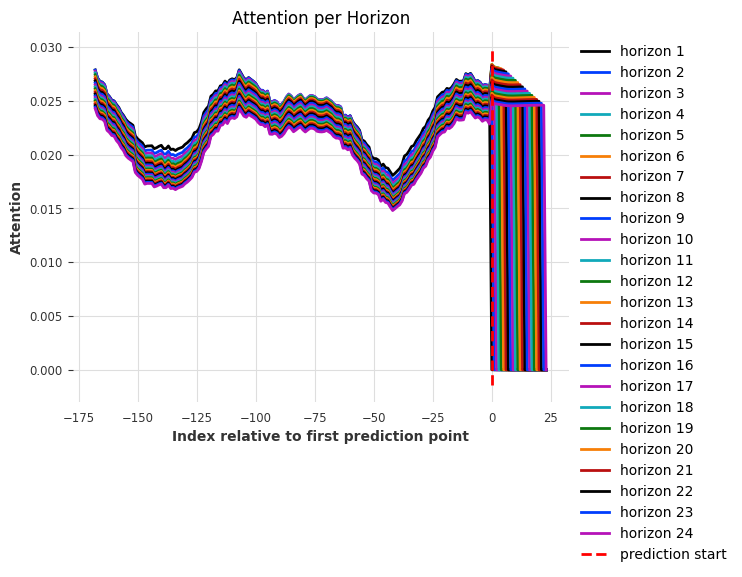

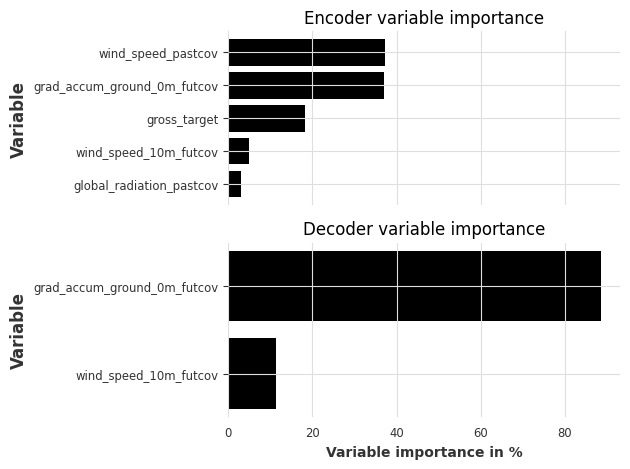

In [73]:
from darts.explainability.tft_explainer import TFTExplainer

explainer = TFTExplainer(model)
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)